# Find Previous fall injuries
The first of two tasks for Region Halland was identifying previous fall injuries from free text journal notes for patients. The aim for this application was to verify if a model can be trained and used to find previous fall injuries.    

Identifying from past journal texts which patients has had a fall injury is a time consuming process and requires the review of a domain expert for verification. Region Halland would, therefore, be able to identify the journals that are most likely to be a fall injury before-hand, to reduce the number of journals under review by a medical expert.   

--- 

The dataset available had already some annotations from 2016, where about 150.000 journal texts had been annotated; of those annotated examples were 302 confirmed fall injuries. Because of the highly imbalanced dataset, we reduced the number of data points used in the training to ~1800 samples in the training set. Because of sparsity of journals with a confirmed fall injury, we chose to keep all those annotations and *under sample* data points from the other class.  

#### About this notebook
This notebook and all others are **not** included with the original dataset from Region Halland because the sensitive nature of the date. Instead we have transformed a wholy new dataset. No personal data is used in the creation of this sample/synthetic dataset, rather we have used reviews from a openly available dataset in free text form to represent the patient journal texts. We then tried to replicate features of the original dataset to the synthetic dataset, s.a. distribution of patient age, gender, entires per year and distribution of patients in year and age that suffer a fall injury. 

The goal of this synthetic dataset is mearly to highlight the code and method used in the project and why, to, in the extent possible, provide reproducable research in a importaint domain with nessisary restrictions of privacy and data sharing.

![2016_class_imbalance.png](./images/02_2016_class_imbalance.png)

#### To the extent  possible, we will try to show visualizations from the original dataset and compare with the results on the synthetic dataset.

## Test and compare models for finding previous fall injuries
First, we inspect and compare three different models, two more traditional machine learning models (SVC and Random Forest) and one deep learning based model (Swedish BERT).   

All machine learning models that deal with text need to represent it in some meaningful way to extract semantic meaning, by representing the text as a *word embedding*. For traditional models, such  as SVC and Random Forest, This can be done in multiple way; and we will be going for a TF-IDF vectorization (a weighted Bag-of-Words method), since it is simple, effective and interpratable. For the BERT models, the word embedding is built in to the model and learned during training.

For the traditional ML models, we also inspect the feature importance of specific words or *n-grams*. Several word n-grams and character n-grams were compared, and we found the models not to benifit from n-grams (for words) larger than 2.   
 
Feature importance for a model is hard to interpret when including n-gram words and n-gram characters. Therefore, then for plotting feature importance, we exclude character n-gram.  

In [8]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    precision_recall_curve,
    recall_score,
)

from sklearn.model_selection import cross_val_score

import matplotlib
matplotlib.use('Agg')

%matplotlib inline


def plot_roc_curve(y_true, y_probs, figure_name=None):
    """Make ROC curve if clf model has predictons with `clf.predict_proba()`."""
    
    # Line choices: '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(6, 4))
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='AUC (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='dashed')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('True Positive Rate', fontsize=14)
    plt.ylabel('False Positive Rate', fontsize=14)
    plt.title('')
    plt.legend(loc="lower right")
    
    plt.show()
    
    if figure_name is not None:
        plt.savefig(figure_name)

In [9]:
def plot_confusion_matrix(cm, class_names, figure_name=None, all_horizontal=True, title=None, cmap=plt.cm.Blues, normalize=True):
    """Plot the confusion matrix for a Sklearn model. 
    
    Uses a pre-computed confusion matrix"""
    
    # Normailze the values across the True labels if "normalize"
    if normalize:
        cm = cm.astype(float)
        _cm = np.array(cm)
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            _cm[i,j] = float(cm[i,j]) / sum(cm[i])
        cm = _cm
            
    plt.figure(figsize=(8,5))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0, fontsize=15)
    plt.yticks(tick_marks, class_names, rotation=(0 if all_horizontal else 90), fontsize=15)
    
    plt.ylabel('True Label',fontsize=20)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.colorbar()
    plt.tight_layout()
    
    if title is not None:
        plt.title(title, fontsize=16)
        
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i,j]
        if normalize:
            plt.text(j, i, "{:.3f}".format(val), horizontalalignment="center",fontsize=15, color="white" if val > thresh else "black")
        else:
            plt.text(j, i, "{:.0f}".format(val), horizontalalignment="center",fontsize=15, color="white" if val > thresh else "black")
    
    if figure_name is not None:
        plt.savefig(figure_name)

In [10]:
features: FeatureUnion = None


def vectorize(text_fit, text_transform=None, train=False, use_char_vectorizer=False, max_num_words=2):
    """Apply a TF-IDF vectorization on the text data."""
    char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                                      use_idf=True, 
                                      norm='l2',
                                      analyzer='char', 
                                      smooth_idf=True,
                                      sublinear_tf=True)
    word_vectorizer = TfidfVectorizer(ngram_range=(1, max_num_words), 
                                      use_idf=True, 
                                      norm='l2',
                                      analyzer='word', 
                                      smooth_idf=True,
                                      sublinear_tf=True)
    
    
    feature_transforms = [('words', word_vectorizer)]
    if use_char_vectorizer:
        feature_transforms.append(('chars', char_vectorizer))
    
    global features
    features = FeatureUnion(feature_transforms)
    
    x_train = features.fit_transform(text_fit)
    x_valid = None
    
    if text_transform is not None:
        x_valid = features.transform(text_transform)
    
    return x_train, x_valid, features


def load_data(train_path='../data/rh_train.csv', 
              valid_path=None, 
              is_testing=False):
    
    train = pd.read_csv(train_path)
    
    x_train, y_train = train['text'], train['label']
    x_valid = None
    y_valid = None
    
    if valid_path is not None:
        valid = pd.read_csv(valid_path)
        x_valid = valid['text']
        if not is_testing:
            y_valid = valid['label']
    
    
    x_train, x_valid, word_vectorizer = vectorize(x_train, x_valid)
    
    return (x_train, y_train, x_valid, y_valid, word_vectorizer)

In [11]:
def plot_results(clf, x_train, y_train, x_valid, y_valid, y_prob, model_name=None):
    """Plot confusion matrix and ROC curve."""
    class_names = ["Ej Ramlat", "Ramlat"]
    disp = metrics.plot_confusion_matrix(clf, x_valid, y_valid, 
                                         display_labels=class_names, 
                                         cmap=plt.cm.Blues,normalize='true');
    
    if model_name is not None:
        plot_roc_curve(y_valid, y_prob, 
                       figure_name=f"{model_name}_ROC.png")
    
        plot_confusion_matrix(cm=disp.confusion_matrix, 
                              class_names=class_names, 
                              figure_name=f"{model_name}_confusion_matrix.png")
    
def print_results(y_valid, y_pred):
    print("Score:")
    print("acc: ", round(accuracy_score(y_true=y_valid, y_pred=y_pred), 4))
    print("prec:", round(precision_score(y_true=y_valid, y_pred=y_pred), 4))
    print("rec: ", round(recall_score(y_true=y_valid, y_pred=y_pred), 4))
    print("f1:  ", round(f1_score(y_true=y_valid, y_pred=y_pred), 4))
    
    
def plot_feature_importance(clf, features, model_name=None):
    """Plot feature importance for different classification models."""

    def _plot_features(features, words, top=-1, model_name=None, show_highest_at_top=True):
        importance, words = zip(*sorted(list(zip(features, words))))
        if top == -1:
            top = len(names)
            
        importance = importance[::-1]
        words = [w.split("words__")[-1] for w in words]
        words = words[::-1]
        
        plt.figure()
        plt.figure(figsize=(8,5))
        plt.title("Feature Importance")
        plt.barh(range(top), importance[0:top], align='center', color="#4177a6")
        
        if show_highest_at_top:
            plt.gca().invert_yaxis()
        
        plt.yticks(range(top), words[0:top])
        plt.show()

        if model_name is not None:
            plt.savefig(f"{model_name}_feature_importance.png")
    
    
    feature_names = features.get_feature_names_out()
    
    if isinstance(clf, SVC):
        _plot_features(abs(clf.coef_.toarray()[0]), feature_names, top=16);
    elif isinstance(clf, RandomForestClassifier):
        _plot_features(abs(clf.feature_importances_), feature_names, top=16);
    else:
        print("The current model is not yet implemented to show feature importance!")
        raise NotImplemented

In [12]:
def train_predict(clf, 
                  train_path='../data/rh_train.csv', 
                  valid_path='../data/rh_valid.csv', 
                  is_testing=False, 
                  model_name=None):
    
    """Train and evaluate the preformance of predictive classification models."""
    
    x_train, y_train, x_valid, y_valid, features = load_data(train_path=train_path, 
                                                                    valid_path=valid_path,
                                                                    is_testing=is_testing)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_valid)
    y_prob = clf.predict_proba(x_valid)
    
    # Plot and print results
    if not is_testing:
        plot_results(clf, x_train, y_train, x_valid, y_valid, y_prob, model_name=model_name)
        plot_feature_importance(clf, features, model_name=model_name)
        print_results(y_valid, y_pred)
    
    return y_pred


def save_predicted_labels(predictions, model_name=None):
    # Store the patients the model predicts has had a fall injury
    d = {'label': predictions}
    df = pd.DataFrame(data=d)
    if model_name is not None:
        print("Saving the predicted labels from the model...")
        df.to_csv(f"../data/predicted_labels_past_fallinjuries_{model_name}_2017.csv")

## SVC with TF-IDF Vectorizer
Compare the result of the model on the synthetic dataset to the result achived on the actual dataset (see image):

![SVC confusion matrix on real data](./images/02_SVC_confusion_matrix_real_data.png)
The figure above shows the resutls of the model on the real dataset

/home/markussagen/.pyenv/versions/medbert/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


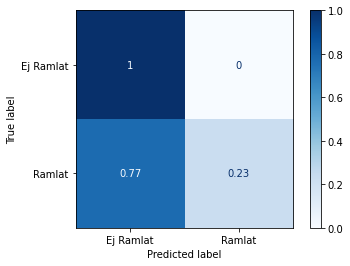

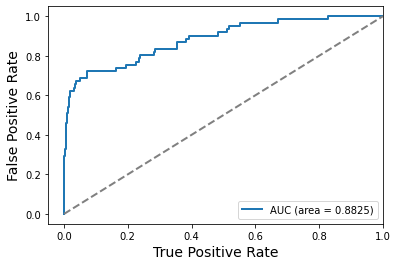

<Figure size 432x288 with 0 Axes>

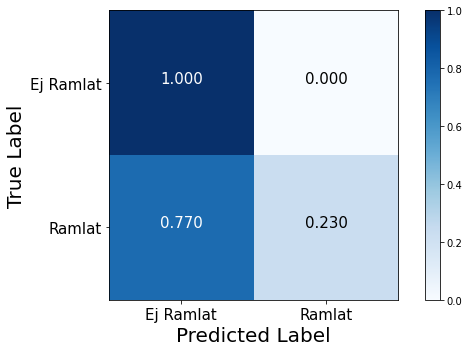

<Figure size 432x288 with 0 Axes>

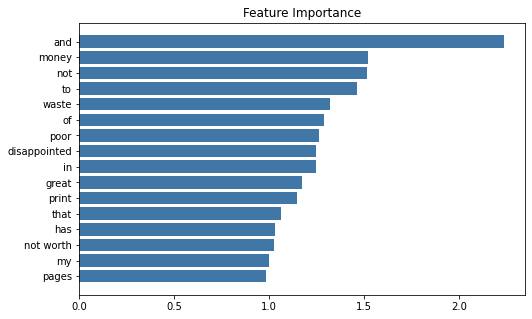

Score:
acc:  0.8705
prec: 1.0
rec:  0.2295
f1:   0.3733
Saving the predicted labels from the model...


In [13]:
# Train and predict 
model_name = "SVC"
clf = SVC(kernel='linear', probability=True, random_state=42)

predictions = train_predict(clf, 
                            train_path='../data/rh_train.csv', 
                            valid_path='../data/rh_valid.csv', 
                            is_testing=False,
                            model_name=model_name)

save_predicted_labels(predictions, model_name=model_name)

## Random Forest with TF-IDF Vectorizer
Compare the result of the model on the synthetic dataset to the result achived on the actual dataset (see image):

![Random Forest confusion matrix on real data](./images/02_RandomForest_confusion_matrix_real_data.png)
The figure above shows the resutls of the model on the real dataset

/home/markussagen/.pyenv/versions/medbert/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


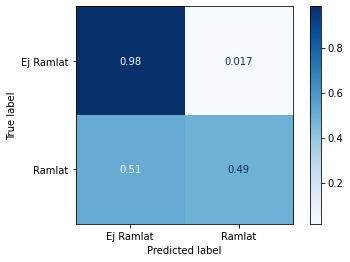

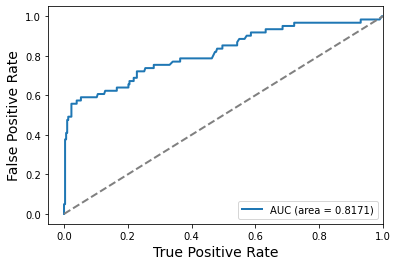

<Figure size 432x288 with 0 Axes>

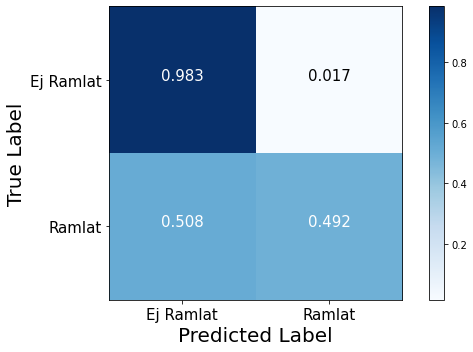

<Figure size 432x288 with 0 Axes>

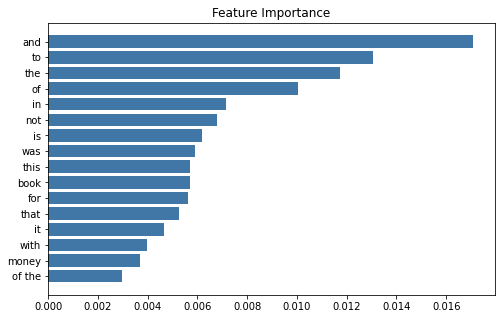

Score:
acc:  0.9008
prec: 0.8571
rec:  0.4918
f1:   0.625
Saving the predicted labels from the model...


In [12]:
# Train and predict 
model_name = "RF"
clf = RandomForestClassifier(n_estimators=1000, random_state=42)

predictions = train_predict(clf, 
                            train_path='../data/rh_train.csv', 
                            valid_path='../data/rh_valid.csv', 
                            is_testing=False,
                            model_name=model_name)

save_predicted_labels(predictions, model_name=model_name)

## Swedish BERT
Compare the result of the model on the synthetic dataset to the result achived on the actual dataset (see image):

![BERT confusion matrix on real data](./images/02_BERT_confusion_matrix_real_data.png)
The figure above shows the resutls of the model on the real dataset

In [ ]:
# **NOTE** because the model itself takes a long time to train
# we have instead chosen to provided the BERT code in the `scripts` folder instead!

The results from these graphs do not represent the results or preformance of the models trained on the real dataset. This mearly aims to illustrate the methodology used when addressing the issue and building machine learning models for the specific problem.

In the case of the feature importance visualizations, from the example data it is clear that stop words are included in the decision of the model and we could apply stop-word removal to reduce their influence in the model. For the real models, trained on the real dataset, this influence was not detected and we, therefore, decided not to include it. 

## Cross Validation
The model performance is verified by splitting the training and validation set into differing folds. The result from training the models on these differing splits is averaged to measure the models robustness to new unseen data.   

To mitigate the class imbalance between the patients that has had a fall injury or not, we only include about 1800 examples in total for the dataset to be split into k-folds.  

Keep in mind that the results shown here from the cross-validation is far poorer than the results achieved on the actual dataset.

## SVC - Cross validation

In [42]:
# K-fold cross validation will create the train-validation splits them selves
from sklearn.preprocessing import LabelBinarizer


X, y, _, _, _ = load_data(train_path='../data/rh_all_2016_data.csv')

lb = LabelBinarizer()
y = np.array([label[0] for label in lb.fit_transform(y)])

k_fold = 5
clf = SVC(kernel='linear', probability=True, random_state=42)


print("Accuracy :", cross_val_score(clf, X, y, cv=k_fold, scoring='accuracy').mean())
print("Precision:", cross_val_score(clf, X, y, cv=k_fold, scoring='precision').mean())
print("Recall   :", cross_val_score(clf, X, y, cv=k_fold, scoring='recall').mean())
print("F1       :", cross_val_score(clf, X, y, cv=k_fold, scoring='f1').mean())

Accuracy : 0.8730697228437059
Precision: 0.9779761904761906
Recall   : 0.24502732240437158
F1       : 0.3889682117752294


## Random Forest - Cross validation

In [44]:
# K-fold cross validation will create the train-validation splits them selves
from sklearn.preprocessing import LabelBinarizer


X, y, _, _, _ = load_data(train_path='../data/rh_all_2016_data.csv')

lb = LabelBinarizer()
y = np.array([label[0] for label in lb.fit_transform(y)])

k_fold = 5
clf = RandomForestClassifier(n_estimators=1000, random_state=42)


print("Accuracy :", cross_val_score(clf, X, y, cv=k_fold, scoring='accuracy').mean())
print("Precision:", cross_val_score(clf, X, y, cv=k_fold, scoring='precision').mean())
print("Recall   :", cross_val_score(clf, X, y, cv=k_fold, scoring='recall').mean())
print("F1       :", cross_val_score(clf, X, y, cv=k_fold, scoring='f1').mean())

Accuracy : 0.9028857129811424
Precision: 0.9587121212121211
Recall   : 0.43765027322404376
F1       : 0.5970092793697062


# Export predictions
The fine-tuned models were finally used to predict the patients that had a fall injury on a with-held testset of patients from 2017. The predicted labels for each model were saved to a Excel file and verified by Region Halland.   

The resulting confusion matrix from evaluating against the test set are as follows:

#### The number of fall injuries that occured on the 2017 test set predicted by the respective models

In [502]:
len(pos_bert), len(pos_svc), len(pos_rf)

(2370, 905, 562)

#### Plot the results of the confusion matrices

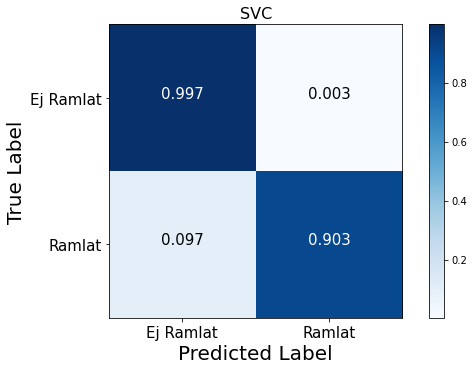

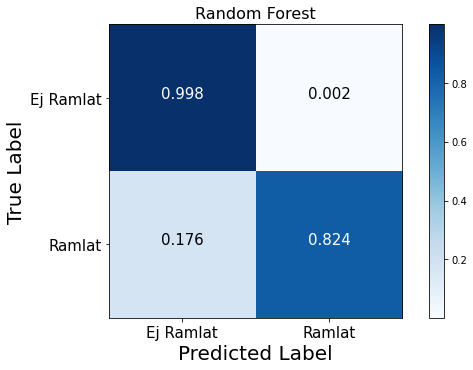

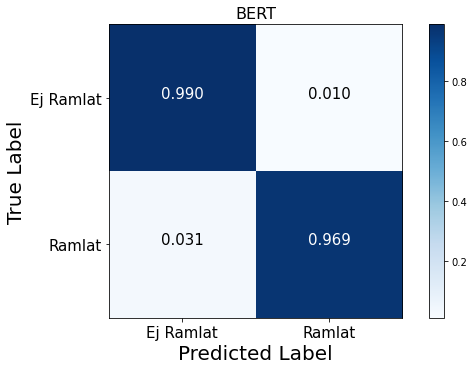

In [17]:
class_names = ["Ej Ramlat", "Ramlat"]

# SVC
plot_confusion_matrix(cm=np.array([[168504, 472], [28, 262]]), 
                      class_names=class_names, 
                      normalize=True, 
                      title="SVC",
                      figure_name="SVC_2017_synthetic.png")

# RF
plot_confusion_matrix(cm=np.array([[168701, 275], [51, 239]]), 
                      class_names=class_names, 
                      normalize=True, 
                      title="Random Forest",
                      figure_name="RF_2017_synthetic.png")
              
# Bert
plot_confusion_matrix(cm=np.array([[167355, 1621], [9, 281]]), 
                      class_names=class_names, 
                      normalize=True, 
                      title="BERT",
                      figure_name="BERT_2017_synthetic.png")

But, because the problem has many aspects to it, we also looked at the number of examples the model miss-classifies. As we can see in the confusion matrix below, thought BERT seems to be a great model for identifying past fall injuries, when inspecting the number of total *false positive* and *false negative* predictions, it falls short.   

The reason is that the models should be considered in the context that they will be used:
- Each prediction made by the model must later be fact checked by a domain expert to be relied on in practice and by medical professionals.
- The models should minimize the number of false positives and false negatives (precison/recall trade-off).
- Since the number of false positive + true positives are the total number journals a domain expert will inspect. It is very inefficient to use the BERT model, which predicts 4X more samples for review as the other models, while not improving on the true positive predictions sufficiently. Medical health experts have limited time to review journal entries suggested by a model, and therefore, both a Random Forest and SVC could be more applicable.

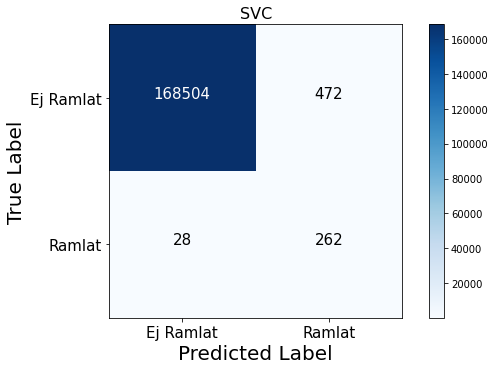

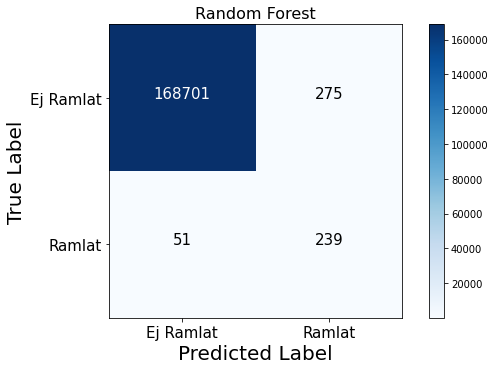

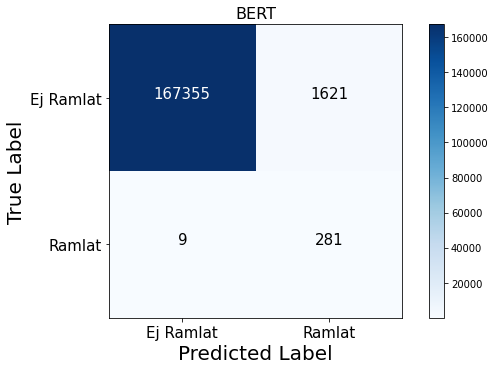

In [18]:
class_names = ["Ej Ramlat", "Ramlat"]

# SVC
plot_confusion_matrix(cm=np.array([[168504, 472], [28, 262]]), 
                      class_names=class_names, 
                      normalize=False, 
                      title="SVC",
                      figure_name="SVC_2017_synthetic.png")

# RF
plot_confusion_matrix(cm=np.array([[168701, 275], [51, 239]]), 
                      class_names=class_names, 
                      normalize=False, 
                      title="Random Forest",
                      figure_name="RF_2017_synthetic.png")
              
# Bert
plot_confusion_matrix(cm=np.array([[167355, 1621], [9, 281]]), 
                      class_names=class_names, 
                      normalize=False, 
                      title="BERT",
                      figure_name="BERT_2017_synthetic.png")